# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.3.1
- DoWhy 0.12
- scipy 1.15.3

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

In [2]:
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z1 = stats.norm(scale=2)
        self.u_z2 = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z1 = self.u_z1.rvs(sample_size)
        u_z2 = self.u_z2.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.2*gps + 0.35*u_z1 
        sensoring = 0.25*u_z2 - 0.2*hippocampus
        memory = 0.45*u + 0.25*sensoring
        
        return gps, hippocampus, sensoring, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

## Actividad en clase

Haga lo siguiente:

- Observe que se introdujo la variable observable sensoring entre hippocampus y memory. 
- Instancie el modelo y cree el df a partir de las variables observables.
- Cree el grafo conforme con el modelo.
- Cree el modelo declarando como efecto Y y como variable a intervenir X.
- Identifique la relación causal entre X e Y a partir del modelo
- Cuanto termine, me avisa para entregarle una **L (logrado)**.
- Recuerde que cada L es una décima más en la nota de la asignatura.
- Pueden trabajar de a dos.

***Tiene hasta el final de la clase.***


# Solución

In [3]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, sensoring_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, sensoring_obs, memory_obs]).T, columns=['X', 'Z1', 'Z2', 'Y'])

In [4]:
gml_graph = """
graph [
    directed 1
    
    node [
        id "X" 
        label "X"
    ]    
    node [
        id "Z1"
        label "Z1"
    ]
    node [
        id "Z2"
        label "Z2"
    ]
    node [
        id "Y"
        label "Y"
    ]
    node [
        id "U"
        label "U"
    ]
    
    edge [
        source "X"
        target "Z1"
    ]
    edge [
        source "Z1"
        target "Z2"
    ]
    edge [
        source "Z2"
        target "Y"
    ]
    edge [
        source "U"
        target "Y"
    ]
]
"""

/home/marcelo/.local/lib/python3.10/site-packages/dowhy/causal_model.py:583: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


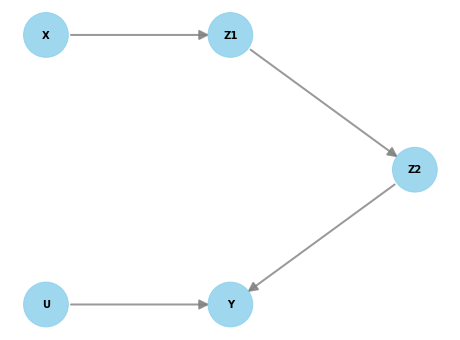

In [5]:
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_graph
)


model.view_model()

In [6]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡    d         ∂            ⎤
E⎢─────────(Y)⋅────([Z₁  Z₂])⎥
 ⎣d[Z₁  Z₂]    ∂[X]          ⎦
Estimand assumption 1, Full-mediation: Z1,Z2 intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z1,Z2} then P(Z1,Z2|X,U) = P(Z1,Z2|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z1,Z2} and U→Y then P(Y|Z1,Z2, X, U) = P(Y|Z1,Z2, X)

